# Importing the necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from zipfile import ZipFile
# !pip install plotly
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
import plotnine as pn
import plydata.cat_tools as cat
# machine learning
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Importing the lifetimes package
import lifetimes
from sklearn.metrics import mean_absolute_error

# Loading the Data

In [2]:
# Laoding the data into a dataframe.
CDNOW_DATA = pd.read_csv("Data/CDNOW_master.txt", sep='\s+')
CDNOW_DATA.shape

(69658, 4)

In [3]:
CDNOW_DATA.head() # Looking at the top 5 rows of the dataframe.

,00001,19970101,1,11.77
0,2,19970112,1,12.00
1,2,19970112,5,77.00
2,3,19970102,2,20.76
3,3,19970330,2,20.76
4,3,19970402,2,19.54


# Data Cleaning

In [4]:
CDNOW_DATA.info() # info() gives us the number of non null values and the data type of each column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69658 entries, 0 to 69657
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   00001     69658 non-null  int64  
 1   19970101  69658 non-null  int64  
 2   1         69658 non-null  int64  
 3   11.77     69658 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.1 MB


In [5]:
CDNOW_DATA.columns = ["CustomerID", "TransactionDate", "UnitsSold", "Price"] # Assigning the column names to the data frame.

In [6]:
CDNOW_DATA["CustomerID"] = CDNOW_DATA["CustomerID"].astype(str) # changing the datatype of the CustomerID to string.

In [7]:
# changing the datatye of the TransactionDate column to datetime.
CDNOW_DATA['TransactionDate'] = CDNOW_DATA['TransactionDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d'))

In [8]:
CDNOW_DATA.head()  # Looking at the top 5 rows of the dataframe.

,CustomerID,TransactionDate,UnitsSold,Price
0,2,1997-01-12,1,12.00
1,2,1997-01-12,5,77.00
2,3,1997-01-02,2,20.76
3,3,1997-03-30,2,20.76
4,3,1997-04-02,2,19.54


# Machine Learning Modelling

### Feature Engineering

In [9]:
n_days = 90 # The no of days for which we want to predict CLV.
max_date = CDNOW_DATA['TransactionDate'].max() # Getting the max transaction date.
cutoff = max_date - pd.to_timedelta(n_days, unit = 'd') # Creating a cut off to exclude the last 90 days.

In [10]:
IN_DATA = CDNOW_DATA[CDNOW_DATA['TransactionDate'] <= cutoff] # Excluding the last 90 days.
OUT_DATA = CDNOW_DATA[CDNOW_DATA['TransactionDate'] > cutoff] # Just the last 90 days data.

In [11]:
# making targets from out data
TARGET_DATA = OUT_DATA.drop('UnitsSold', axis = 1).groupby('CustomerID').sum().rename({'Price':'spend_90_total'}, axis = 1).assign(spend_90_flag = 1)
TARGET_DATA.head()

,spend_90_total,spend_90_flag
CustomerID,,
100,28.98,1
10018,11.88,1
1002,15.48,1
10026,36.48,1
10027,122.33,1


In [12]:
# make recency (date) features from in data
max_date = IN_DATA['TransactionDate'].max()

In [13]:
# Getting the recency data to include that as feature for ML modelling
recency_features_df = IN_DATA[['CustomerID', 'TransactionDate']].groupby('CustomerID').apply(lambda x: (x['TransactionDate'].max() - max_date)/ pd.to_timedelta(1, 'day')).to_frame().set_axis(['recency'], axis = 1)
recency_features_df.head()

,recency
CustomerID,
10,-435.0
100,-111.0
1000,-436.0
10000,-244.0
10001,-174.0


In [14]:
# make frequency (count features from in data)
frequency_features_df = IN_DATA[['CustomerID', 'TransactionDate']].groupby('CustomerID').count().set_axis(['frequency'], axis = 1)
frequency_features_df.head()

,frequency
CustomerID,
10,1
100,2
1000,1
10000,3
10001,2


In [15]:
# make price (monitery features from in data)
price_features_df = IN_DATA.groupby('CustomerID').aggregate({'Price':['sum', 'mean']}).set_axis(['price_sum', 'price_mean'], axis = 1)
price_features_df.head()

,price_sum,price_mean
CustomerID,,
10,39.31,39.310000
100,26.26,13.130000
1000,8.99,8.990000
10000,77.42,25.806667
10001,19.78,9.890000


In [16]:
# combine features
features_df = pd.concat([recency_features_df, frequency_features_df, price_features_df], axis = 1).merge(TARGET_DATA, left_index = True, right_index = True, how = 'left').fillna(0)
features_df.head()

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
CustomerID,,,,,,
10,-435.0,1,39.31,39.310000,0.00,0.0
100,-111.0,2,26.26,13.130000,28.98,1.0
1000,-436.0,1,8.99,8.990000,0.00,0.0
10000,-244.0,3,77.42,25.806667,0.00,0.0
10001,-174.0,2,19.78,9.890000,0.00,0.0


### Regression
> How much will the customers spend in the next 90 days?

### XGBOOST

In [17]:
X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]
# next 90 days spend prediction
y_spend = features_df['spend_90_total']

In [18]:
# Model
xgb_reg_spec = XGBRegressor(objective='reg:squarederror', random_state=123)

In [19]:
# Creating a GridSearchCV to tune the hyperparameters
xgb_reg_model =GridSearchCV(estimator=xgb_reg_spec, param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5]), scoring='neg_mean_absolute_error', cv = 5) 

In [20]:
# Fitting the Model
xgb_reg_model.fit(X, y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=123, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
        

In [21]:
xgb_reg_model.best_score_ # NAE of the best parameters model.

-9.781133759361964

In [22]:
xgb_reg_model.best_params_ # best Hyperparameter value

{'learning_rate': 0.01}

In [23]:
predictions_xgb_reg_model = xgb_reg_model.predict(X) # Prediction

In [24]:
# Merging the predictions to the data.
XGB_PRED_DATA = pd.DataFrame({"prediction_xgb" : predictions_xgb_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)
XGB_PRED_DATA.head()

,prediction_xgb,CustomerID,recency,frequency,price_sum,price_mean
0,0.849789,10,-435.0,1,39.31,39.310000
1,3.596536,100,-111.0,2,26.26,13.130000
2,0.761545,1000,-436.0,1,8.99,8.990000
3,5.035758,10000,-244.0,3,77.42,25.806667
4,3.178706,10001,-174.0,2,19.78,9.890000


In [25]:
XGB_PRED_DATA.to_csv("XGB_reg_prediction.csv") # Writing the predictions to a csv

### Linear Regression

In [26]:
lr = LinearRegression() # Model

In [27]:
parameters = {'fit_intercept':[True,False],  'copy_X':[True, False]} # Hyper parameters.
lr_reg_model = GridSearchCV(lr,parameters, cv=5, scoring='neg_mean_absolute_error')
lr_reg_model.fit(X, y_spend)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error')

In [28]:
lr_reg_model.best_score_ # NAE of the best parameters model.

-11.220285179961735

In [29]:
lr_reg_model.best_params_ # best Hyperparameter value

{'copy_X': True, 'fit_intercept': True}

In [30]:
predictions_lr_reg_model = lr_reg_model.predict(X) # Prediction

In [31]:
# Merging the prediction to the X data.
LINEAR_REGRESSION_PRED_DATA = pd.DataFrame({"prediction_lr" : predictions_lr_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)

In [32]:
LINEAR_REGRESSION_PRED_DATA.to_csv("lr_reg_prediction.csv") # Predictions to CSV

# Random Forest Regression

In [33]:
# Hyper Parameters
param_grid = dict(n_estimators = [10, 20, 50, 100, 500, 1000], max_depth = [2, 5], max_features = ['auto', 'sqrt', 'log2'])

In [34]:
rf = RandomForestRegressor() # model
rf_regressor =GridSearchCV(estimator=rf, param_grid = param_grid, scoring='neg_mean_absolute_error', refit= True, cv = 5) 

In [35]:
rf_regressor.fit(X, y_spend) #fitting the data

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 50, 100, 500, 1000]},
             scoring='neg_mean_absolute_error')

In [36]:
rf_regressor.best_score_ # NAE of the best model.

-10.707215661872791

In [37]:
rf_regressor.best_params_ # Best hyper parameters.

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10}

In [38]:
rf_regressor.best_estimator_

RandomForestRegressor(max_depth=5, n_estimators=10)

In [39]:
predictions_rf_reg_model = rf_regressor.predict(X) # Prediction

In [40]:
# Mergeing the prediction with X data
RF_REGRESSION_PRED_DATA = pd.DataFrame({"prediction_rf" : predictions_rf_reg_model.tolist()}).merge(X.reset_index(),left_index=True, right_index=True)

In [41]:
RF_REGRESSION_PRED_DATA.to_csv("rf_reg_prediction.csv") # Storing the Prediction data in a csv.

### Classification
> Will a customer make a purchase in next 90 days

In [42]:
# Next 90 days spend probability
y_prob = features_df['spend_90_flag']

In [43]:
xgb_clf_spec = XGBClassifier(objective='binary:logistic', random_state= 123) # model

In [44]:
xgb_clf_model =GridSearchCV(estimator=xgb_clf_spec, param_grid = dict(learning_rate = [0.01, 0.1, 0.3, 0.5]), scoring='roc_auc', refit= True, cv = 5) 

In [45]:
xgb_clf_model.fit(X, y_prob) # Fitting the data

[12:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=123, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=

In [46]:
xgb_clf_model.best_score_ # AUC score of the best model

0.8374299116243062

In [47]:
xgb_clf_model.best_params_ # Best Hyperparameter Values

{'learning_rate': 0.01}

In [48]:
# Storing the prediction values in a dataframe
XGB_CLASSIFICATION_PRED_DATA = pd.DataFrame(xgb_clf_model.predict_proba(X),columns=['prediction_xgb_clf_0','prediction_xgb_clf_1']).merge(X.reset_index(),left_index=True, right_index=True)
XGB_CLASSIFICATION_PRED_DATA.head()

,prediction_xgb_clf_0,prediction_xgb_clf_1,CustomerID,recency,frequency,price_sum,price_mean
0,0.799550,0.200450,10,-435.0,1,39.31,39.310000
1,0.733550,0.266450,100,-111.0,2,26.26,13.130000
2,0.799550,0.200450,1000,-436.0,1,8.99,8.990000
3,0.700524,0.299476,10000,-244.0,3,77.42,25.806667
4,0.726561,0.273439,10001,-174.0,2,19.78,9.890000


In [49]:
XGB_CLASSIFICATION_PRED_DATA.to_csv("xgb_clf_prediction.csv") # Predictions to csv

### Logistic Regression

In [50]:
parameters = {'penalty': ["l1", "l2"], 'solver': ["liblinear","saga"]} # Hyper parameters

logr = LogisticRegression() # model
logr_clf_model = GridSearchCV(logr,parameters, cv=5, scoring='accuracy')
logr_clf_model.fit(X, y_prob) #fitting

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [51]:
logr_clf_model.best_params_ # Best Hyperparameters

{'penalty': 'l1', 'solver': 'liblinear'}

In [52]:
logr_clf_model.best_score_ # AUC score of the best model

0.8804362247031362

In [53]:
# Storing the prediction values in a dataframe with X data
LOGISTIC_CLASSIFICATION_PRED_DATA = pd.DataFrame(logr_clf_model.predict_proba(X),columns=['prediction_log_clf_0','prediction_log_clf_1']).merge(X.reset_index(),left_index=True, right_index=True)
LOGISTIC_CLASSIFICATION_PRED_DATA.head()

,prediction_log_clf_0,prediction_log_clf_1,CustomerID,recency,frequency,price_sum,price_mean
0,0.968336,0.031664,10,-435.0,1,39.31,39.310000
1,0.784891,0.215109,100,-111.0,2,26.26,13.130000
2,0.969343,0.030657,1000,-436.0,1,8.99,8.990000
3,0.875837,0.124163,10000,-244.0,3,77.42,25.806667
4,0.843597,0.156403,10001,-174.0,2,19.78,9.890000


In [54]:
LOGISTIC_CLASSIFICATION_PRED_DATA.to_csv("log_clf_prediction.csv") # Prediction to csv.

### RANDOM FOREST CLASSIFICATION

In [55]:
#Hyper Parameters
parameters = { 'max_depth' : [2, 5], 'n_estimators' : [10, 20, 50, 100, 500, 1000],'max_features' : ['auto', 'sqrt', 'log2']}

rfc = RandomForestClassifier() # mdoel
rfc_clf_model = GridSearchCV(rfc, parameters, cv=5, scoring='roc_auc') 
rfc_clf_model.fit(X, y_prob) # fitting the data

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 20, 50, 100, 500, 1000]},
             scoring='roc_auc')

In [56]:
rfc_clf_model.best_params_ # Best parameters

{'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50}

In [57]:
rfc_clf_model.best_score_ # AUC score of the best model.

0.8393891812459564

In [58]:
# Storing the prediction values
RF_CLASSIFICATION_PRED_DATA = pd.DataFrame(rfc_clf_model.predict_proba(X),columns=['prediction_rf_clf_0','prediction_rf_clf_1']).merge(X.reset_index(),left_index=True, right_index=True)
RF_CLASSIFICATION_PRED_DATA.head()

,prediction_rf_clf_0,prediction_rf_clf_1,CustomerID,recency,frequency,price_sum,price_mean
0,0.973404,0.026596,10,-435.0,1,39.31,39.310000
1,0.846114,0.153886,100,-111.0,2,26.26,13.130000
2,0.970509,0.029491,1000,-436.0,1,8.99,8.990000
3,0.799749,0.200251,10000,-244.0,3,77.42,25.806667
4,0.863526,0.136474,10001,-174.0,2,19.78,9.890000


In [59]:
RF_CLASSIFICATION_PRED_DATA.to_csv("rf_clf_prediction.csv") # Predictions to csv.

### Feature importance

In [60]:
#importance | spend amount model

imp_spend_amount_dict = xgb_reg_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

In [61]:
imp_spend_amount_df = pd.DataFrame(data = {'feature': list(imp_spend_amount_dict.keys()), 
                                  'value': list(imp_spend_amount_dict.values())}).assign(feature = lambda x : cat.cat_reorder(x['feature'], x['value']))

In [62]:
imp_spend_amount_df

,feature,value
0,recency,161406.093750
1,frequency,149993.890625
2,price_sum,636198.500000
3,price_mean,34036.613281


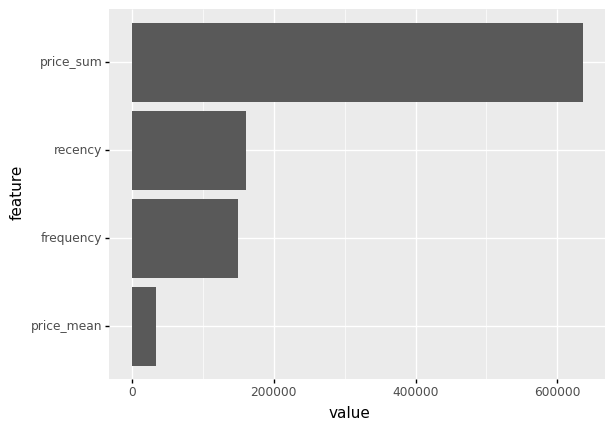

<ggplot: (149792172882)>

In [63]:
pn.ggplot(pn.aes('feature', 'value'), data = imp_spend_amount_df) + pn.geom_col() + pn.coord_flip() #plot of feature importance.

In [64]:
# Importance | Spend probability model
imp_spend_prob_dict = xgb_clf_model.best_estimator_.get_booster().get_score(importance_type = 'gain')

In [65]:
imp_spend_prob_df = pd.DataFrame(data = {'feature': list(imp_spend_prob_dict.keys()), 
                                   'value': list(imp_spend_prob_dict.values())}).assign(feature = lambda x : cat.cat_reorder(x['feature'], x['value']))

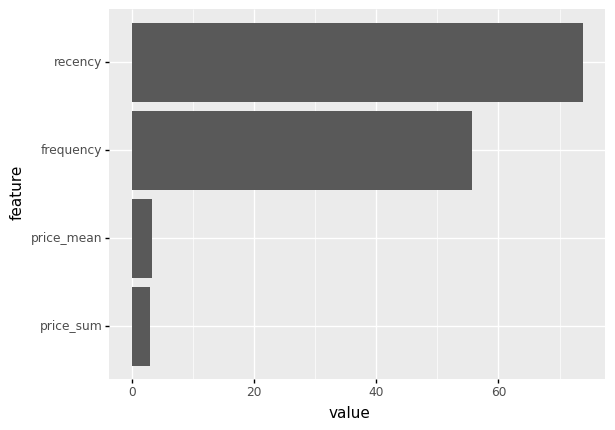

<ggplot: (149801488933)>

In [66]:
pn.ggplot(pn.aes('feature', 'value'), data = imp_spend_prob_df) + pn.geom_col() + pn.coord_flip() #plot of feature importance.

# Lifetimes Library

In [67]:
CDNOW_DATA = CDNOW_DATA[CDNOW_DATA['Price'] > 0]
TRAIN = CDNOW_DATA[CDNOW_DATA["TransactionDate"] < CDNOW_DATA["TransactionDate"].max() - dt.timedelta(days = 30)]
TRAIN.shape

(67467, 4)

In [68]:
TEST =  CDNOW_DATA[CDNOW_DATA["TransactionDate"] >= CDNOW_DATA["TransactionDate"].max() - dt.timedelta(days = 30)]
TEST.shape

(2111, 4)

In [69]:
CDNOW_data_LT = lifetimes.utils.summary_data_from_transaction_data(TRAIN, 'CustomerID', 'TransactionDate', 'Price' )
CDNOW_data_LT.head()

# frequency: total number of repeat purchases
# recency: the difference between the customer's last purchase and his first purchase
# T: the age of the client in the company
# monetary_value: average earnings per purchase

,frequency,recency,T,monetary_value
CustomerID,,,,
10,0.0,0.0,494.0,0.000
100,2.0,474.0,514.0,20.735
1000,0.0,0.0,495.0,0.000
10000,2.0,175.0,478.0,31.525
10001,1.0,245.0,478.0,12.990


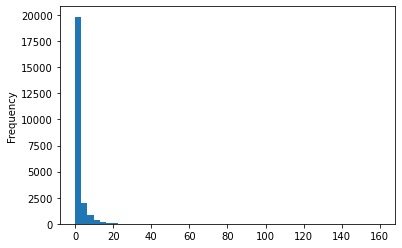

count    23501.000000
mean         1.786647
std          3.963537
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        160.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers that purchased the item only once: 51.42 %


In [70]:
# Create a distribution of frequency to understand the customer frequency level
CDNOW_data_LT['frequency'].plot(kind='hist', bins=50)
plt.show()
print(CDNOW_data_LT['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(CDNOW_data_LT['frequency'] == 0)/float(len(CDNOW_data_LT))*(100),2)
print("Percentage of customers that purchased the item only once:", one_time_buyers ,"%")

In [71]:
# Fitting the BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(CDNOW_data_LT['frequency'], CDNOW_data_LT['recency'], CDNOW_data_LT['T'])

<lifetimes.BetaGeoFitter: fitted with 23501 subjects, a: 0.49, alpha: 41.74, b: 2.06, r: 0.27>

In [72]:
# Model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.270222,0.003751,0.262870,0.277575
alpha,41.739415,0.964840,39.848329,43.630501
a,0.489876,0.027509,0.435958,0.543793
b,2.055083,0.151340,1.758456,2.351709


In [73]:
# Compute the customer alive probability
CDNOW_data_LT['probability_alive'] = bgf.conditional_probability_alive(CDNOW_data_LT['frequency'], CDNOW_data_LT['recency'], CDNOW_data_LT['T'])
CDNOW_data_LT.head(10)

,frequency,recency,T,monetary_value,probability_alive
CustomerID,,,,,
10,0.0,0.0,494.0,0.000,1.000000
100,2.0,474.0,514.0,20.735,0.840349
1000,0.0,0.0,495.0,0.000,1.000000
10000,2.0,175.0,478.0,31.525,0.461278
10001,1.0,245.0,478.0,12.990,0.663393
10002,0.0,0.0,478.0,0.000,1.000000
10003,0.0,0.0,478.0,0.000,1.000000
10004,0.0,0.0,478.0,0.000,1.000000
10005,0.0,0.0,469.0,0.000,1.000000


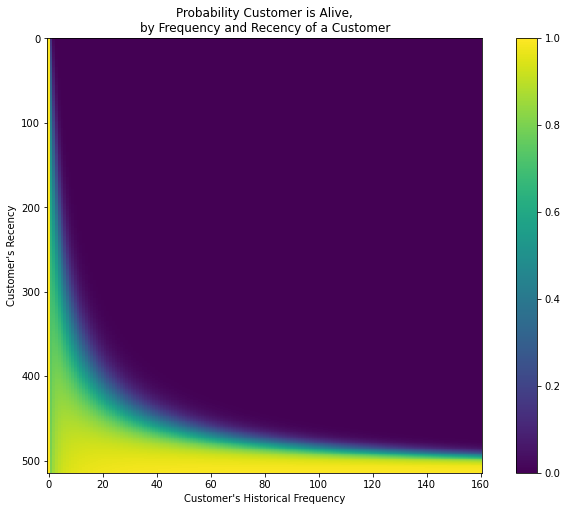

In [74]:
# Visual representation of relationship between recency and frequency
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)
plt.show()

In [75]:
#Predict future transaction for the next 30 days based on historical dataa
t = 30
CDNOW_data_LT['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, CDNOW_data_LT['frequency'], CDNOW_data_LT['recency'], CDNOW_data_LT['T']),2)
CDNOW_data_LT.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,14048,160.0,463.0,465.0,52.730062,0.994300,9.30
1,7592,131.0,483.0,486.0,93.060458,0.992221,7.30
2,22061,111.0,430.0,436.0,33.009640,0.982472,6.76
3,7983,112.0,478.0,481.0,58.564018,0.991799,6.30
4,19597,90.0,444.0,446.0,24.609333,0.992264,5.43
5,3049,75.0,496.0,502.0,50.740533,0.985369,4.04
6,2484,62.0,503.0,504.0,25.641613,0.991366,3.35
7,10079,57.0,463.0,478.0,37.042456,0.956803,3.12
8,4459,57.0,469.0,491.0,31.856316,0.913706,2.91
9,17104,50.0,440.0,454.0,29.721000,0.961075,2.88


In [76]:
# Checking the relationship between frequency and monetary_value
CDNOW_return_customers_summary = CDNOW_data_LT[CDNOW_data_LT['frequency']>0]
print(CDNOW_return_customers_summary.shape)
CDNOW_return_customers_summary.head()

(11416, 6)


,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
CustomerID,,,,,,
100,2.0,474.0,514.0,20.735000,0.840349,0.10
10000,2.0,175.0,478.0,31.525000,0.461278,0.06
10001,1.0,245.0,478.0,12.990000,0.663393,0.05
10009,3.0,262.0,474.0,100.783333,0.594407,0.11
1001,2.0,133.0,510.0,28.335000,0.314353,0.04


In [77]:
# Checking the relationship between frequency and monetary_value
CDNOW_return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.069991
monetary_value,0.069991,1.000000


In [78]:
# Modeling the monetary value using Gamma-Gamma Model
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(CDNOW_return_customers_summary['frequency'],
       CDNOW_return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 11416 subjects, p: 4.11, q: 0.96, v: 3.83>

In [79]:
# Summary of the fitted parameters
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,4.109405,0.044198,4.022777,4.196034
q,0.958532,0.011201,0.936577,0.980487
v,3.831848,0.044178,3.745260,3.918436


In [80]:
# Calculating the conditional expected average profit for each customer per transaction
CDNOW_data_LT_vF = CDNOW_data_LT[CDNOW_data_LT['monetary_value'] >0]
CDNOW_data_LT_vF['exp_avg_sales'] = ggf.conditional_expected_average_profit(CDNOW_data_LT['frequency'],
                                       CDNOW_data_LT['monetary_value'])
CDNOW_data_LT_vF.head()

,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
CustomerID,,,,,,,
100,2.0,474.0,514.0,20.735000,0.840349,0.10,22.765789
10000,2.0,175.0,478.0,31.525000,0.461278,0.06,33.610506
10001,1.0,245.0,478.0,12.990000,0.663393,0.05,16.993327
10009,3.0,262.0,474.0,100.783333,0.594407,0.11,102.405072
1001,2.0,133.0,510.0,28.335000,0.314353,0.04,30.404329


In [81]:
# Checking the expected average value and the actual average value in the data to make sure the values are good
print(f"Expected Average Sales: {CDNOW_data_LT_vF['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {CDNOW_data_LT_vF['monetary_value'].mean()}")

Expected Average Sales: 38.33174958021601
Actual Average Sales: 35.99568193579705


In [82]:
# Predicting Customer Lifetime Value for the next 30 days
CDNOW_data_LT_vF['predicted_clv'] =      ggf.customer_lifetime_value(bgf,
                                                               CDNOW_data_LT_vF['frequency'],
                                                               CDNOW_data_LT_vF['recency'],
                                                               CDNOW_data_LT_vF['T'],
                                                               CDNOW_data_LT_vF['monetary_value'],
                                                               time=1,     # lifetime in months
                                                               freq='D',   # frequency in which the data is present(T)      
                                                               discount_rate=0.01) # discount rate
CDNOW_data_LT_vF.head()

,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
CustomerID,,,,,,,,
100,2.0,474.0,514.0,20.735000,0.840349,0.10,22.765789,2.299704
10000,2.0,175.0,478.0,31.525000,0.461278,0.06,33.610506,1.991479
10001,1.0,245.0,478.0,12.990000,0.663393,0.05,16.993327,0.811097
10009,3.0,262.0,474.0,100.783333,0.594407,0.11,102.405072,11.341482
1001,2.0,133.0,510.0,28.335000,0.314353,0.04,30.404329,1.157153


In [83]:
# Manual CLV pridiction
CDNOW_data_LT_vF['manual_predicted_clv'] = CDNOW_data_LT_vF['pred_num_txn'] * CDNOW_data_LT_vF['exp_avg_sales']
CDNOW_data_LT_vF.head()

,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
CustomerID,,,,,,,,,
100,2.0,474.0,514.0,20.735000,0.840349,0.10,22.765789,2.299704,2.276579
10000,2.0,175.0,478.0,31.525000,0.461278,0.06,33.610506,1.991479,2.016630
10001,1.0,245.0,478.0,12.990000,0.663393,0.05,16.993327,0.811097,0.849666
10009,3.0,262.0,474.0,100.783333,0.594407,0.11,102.405072,11.341482,11.264558
1001,2.0,133.0,510.0,28.335000,0.314353,0.04,30.404329,1.157153,1.216173


### TEST

In [84]:
TEST.head()

,CustomerID,TransactionDate,UnitsSold,Price
37,9,1998-06-08,2,41.98
69,25,1998-06-03,3,24.97
70,25,1998-06-08,2,24.98
194,47,1998-06-06,1,12.99
213,48,1998-06-08,1,9.49


In [85]:
ACTUAL = TEST.groupby("CustomerID")["Price"].sum().reset_index() # Calculating the Sum of Price

In [86]:
ACTUAL.rename(columns ={"Price":"actual_amount_spent_in_next_30_days"}, inplace = True) # renaming the columns

In [87]:
# Actual vs Predicted Dataframe
Pred_vs_Actual = CDNOW_data_LT_vF.merge(ACTUAL, on = "CustomerID", how = "left")
Pred_vs_Actual.fillna(0, inplace = True)

In [88]:
Pred_vs_Actual.head() # looking at the Actual vs Predicted Dataframe

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,actual_amount_spent_in_next_30_days
0,100,2.0,474.0,514.0,20.735000,0.840349,0.10,22.765789,2.299704,2.276579,0.0
1,10000,2.0,175.0,478.0,31.525000,0.461278,0.06,33.610506,1.991479,2.016630,0.0
2,10001,1.0,245.0,478.0,12.990000,0.663393,0.05,16.993327,0.811097,0.849666,0.0
3,10009,3.0,262.0,474.0,100.783333,0.594407,0.11,102.405072,11.341482,11.264558,0.0
4,1001,2.0,133.0,510.0,28.335000,0.314353,0.04,30.404329,1.157153,1.216173,0.0


In [89]:
# difference between actual and predicted
Pred_vs_Actual["difference"] = Pred_vs_Actual["manual_predicted_clv"] - Pred_vs_Actual["actual_amount_spent_in_next_30_days"]

In [90]:
Pred_vs_Actual.head()

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,actual_amount_spent_in_next_30_days,difference
0,100,2.0,474.0,514.0,20.735000,0.840349,0.10,22.765789,2.299704,2.276579,0.0,2.276579
1,10000,2.0,175.0,478.0,31.525000,0.461278,0.06,33.610506,1.991479,2.016630,0.0,2.016630
2,10001,1.0,245.0,478.0,12.990000,0.663393,0.05,16.993327,0.811097,0.849666,0.0,0.849666
3,10009,3.0,262.0,474.0,100.783333,0.594407,0.11,102.405072,11.341482,11.264558,0.0,11.264558
4,1001,2.0,133.0,510.0,28.335000,0.314353,0.04,30.404329,1.157153,1.216173,0.0,1.216173


<AxesSubplot:>

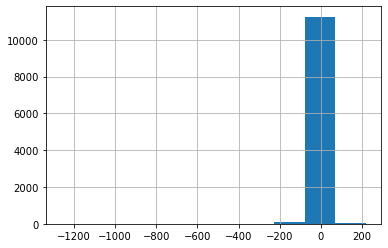

In [91]:
Pred_vs_Actual["difference"].hist()

In [92]:
Pred_vs_Actual["difference"].describe()

count    11416.000000
mean        -0.341102
std         27.547800
min      -1262.237702
25%          0.472827
50%          1.593419
75%          4.734611
max        218.300867
Name: difference, dtype: float64

In [93]:
Pred_vs_Actual.sort_values('actual_amount_spent_in_next_30_days', ascending = False)

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,actual_amount_spent_in_next_30_days,difference
10151,7592,131.0,483.0,486.0,93.060458,0.992221,7.30,93.096880,673.322354,679.607224,1726.80,-1047.192776
10819,8830,9.0,403.0,482.0,54.796667,0.818460,0.43,55.284414,23.499369,23.772298,1286.01,-1262.237702
114,10197,1.0,380.0,473.0,308.790000,0.765091,0.06,315.808672,17.551818,18.948520,587.63,-568.681480
7725,3176,2.0,455.0,502.0,63.745000,0.835507,0.10,65.993896,6.772911,6.599390,563.13,-556.530610
2147,14048,160.0,463.0,465.0,52.730062,0.994300,9.30,52.757339,485.906899,490.643252,534.73,-44.086748
...,...,...,...,...,...,...,...,...,...,...,...,...
4078,17584,1.0,56.0,453.0,21.740000,0.348411,0.03,25.832524,0.679984,0.774976,0.00,0.774976
4079,17585,7.0,446.0,453.0,22.407143,0.936808,0.41,22.987688,9.281901,9.424952,0.00,9.424952
4080,17589,2.0,71.0,453.0,26.535000,0.178413,0.02,28.595201,0.688097,0.571904,0.00,0.571904
4081,1759,4.0,324.0,507.0,47.847500,0.646013,0.15,48.928897,7.229131,7.339335,0.00,7.339335


In [94]:
# MAE of the Lifetimes.
mean_absolute_error(Pred_vs_Actual["actual_amount_spent_in_next_30_days"], Pred_vs_Actual["manual_predicted_clv"])

9.049336545343836